In [1]:
using Graphs
using Plots
using LinearAlgebra
using Statistics
include("../sis.jl")
include("../mpdbp.jl")
include("../exact/montecarlo.jl")
include("../glauber.jl")
include("../test/sib.jl")
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

In [13]:
q = q_sis
T = 20
N = 12
k = 3
gg = random_regular_graph(N, k)
g = IndexedGraph(gg)
λ = 0.15
κ = 0.0
p⁰ = map(1:N) do i
    r = 0.95
    [r, 1-r]
end
ϕ = [[ones(2) for t in 1:T] for i in 1:N]

# throw random observations
nobs = 5
its = rand(collect(Iterators.product(1:N, 1:T)), nobs)
for (i, t) in its
    r = rand()
    ϕ[i][t] .= [r, 1-r]
end
ψ = [[ones(2,2) for t in 1:T] for _ in 1:2*ne(g)]

sis = SIS(g, λ, κ, p⁰, ϕ, ψ);

In [14]:
bp = mpdbp(sis, d=1)
cb = CB_BP(bp);

In [15]:
svd_trunc = TruncThresh(1e-2)
svd_trunc = TruncBond(4)
iters, cb = iterate!(bp, maxiter=100; svd_trunc, cb, tol=1e-3);

Running MPdBP: iter 12 	 Time: 0:00:25
  Δ:  0.0007262980658603868

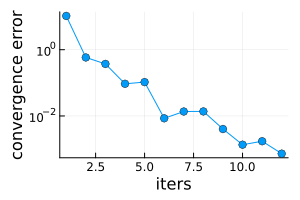

In [16]:
pl_err = plot(cb.Δs, ylabel="convergence error", xlabel="iters", m=:o, yaxis=:log10, 
    size=(300,200), label="")

In [23]:
fe_bp = cb.f[end]
b_bp = beliefs(bp)
p_bp = [[bbb[2] for bbb in bb] for bb in b_bp];

Run sib

In [20]:
b_sib, fe_sib = sib_SI(T, g, ϕ, p⁰, λ)
p_sib = [[bbb[2] for bbb in bb] for bb in b_sib];

sib.iterate(damp=0.0): 65/400 7.494e-15/1e-14      
sib.iterate(damp=0.5): 0/400 2.554e-15/1e-14      
sib.iterate(damp=0.9): 0/400 1.943e-15/1e-14      


SI on random regular graph N=12, k=3. P(S→I)=0.15.
5 random observations.
Max matrix size: 4x4


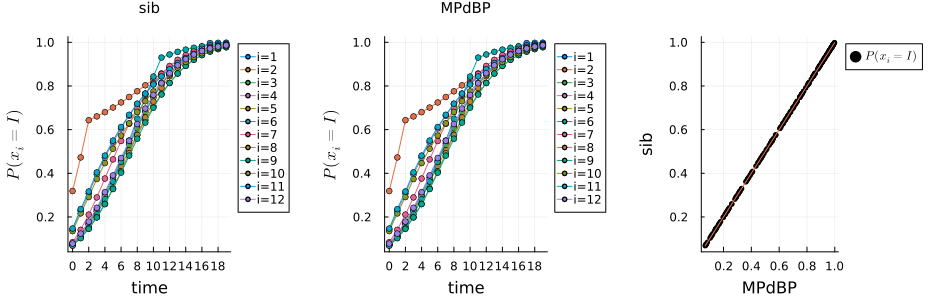

In [21]:
pl_sib = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:2:T-1, title="sib")
for i in 1:N
    plot!(pl_sib, 0:T-1, p_sib[i], label="i=$i", m=:o, ms=3, lw=1)
end
pl_bp = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:2:T-1, title="MPdBP")
for i in 1:N
    plot!(pl_bp, 0:T-1, p_bp[i][1:T], label="i=$i", m=:o, ms=3, lw=1)
end
println("SI on random regular graph N=$N, k=$k. P(S→I)=$λ.")
println("$nobs random observations.")
println("Max matrix size: ", svd_trunc.mprime, "x", svd_trunc.mprime)
pl_sc = scatter(reduce(vcat, [p[1:end-1] for p in p_bp]), reduce(vcat, p_sib), xlabel="MPdBP", 
    ylabel="sib", label="\$P(x_i=I)\$",  ms=3, c=:black, legend=:outertopright)
plot!(pl_sc, identity, label="", size=(300,300))
plot(pl_sib, pl_bp, pl_sc, titlefontsize=10, size=(950, 300), legend=:outertopright, 
    margin=5Plots.mm, layout=(1,3))

In [24]:
fe_bp, fe_sib

(3.8873473337452538, 3.8873624206848296)